In [1]:
import os
import pandas
import matplotlib.pyplot as plt
import seaborn
from tqdm import tqdm
import numpy as np

import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torchvision.transforms.functional as F
from torchvision.utils import make_grid

plt.rcParams["savefig.bbox"] = 'tight'

In [2]:
class CNN_Cinic10(nn.Module):
    def __init__(self):
        super(CNN_Cinic10, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(),
            nn.Conv2d(512, 1024, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(),
            nn.Conv2d(1024, 2048, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(2048),
            nn.LeakyReLU(),
            nn.Flatten()
        )

        self.z_mean = nn.Linear(2048*4*4, 512)
        self.z_log_var = nn.Linear(2048*4*4, 512)

        self.decoder = nn.Sequential(
            nn.Linear(512, 2048*4*4),
            nn.Unflatten(1, (2048, 4, 4)),
            nn.ConvTranspose2d(2048, 1024, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(1024, 512, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),            
            nn.ConvTranspose2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.Conv2d(128, 3, kernel_size=3, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        enc = self.encoder(x)
        mu = self.z_mean(enc)
        lv = self.z_log_var(enc)
        lat = self.reparam(mu, lv)
        dec = self.decoder(lat)
        
        return dec, mu, lv

    def reparam(self, mu, lv):
        std = torch.exp(0.5 * lv)
        eps = torch.randn_like(std)
        return mu + std * eps

    def get_latent(self, x):
        enc = self.encoder(x)
        mu = self.z_mean(enc)
        lv = self.z_log_var(enc)
        lat = self.reparam(mu, lv)

        return lat

In [3]:
mean = [0.47889522, 0.47227842, 0.43047404]
std = [0.24205776, 0.23828046, 0.25874835]

transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),
    ]
)

root_dir = '/media/mountHDD2/data/cinic10'

trainset = ImageFolder(root=root_dir + "/train", transform=transform)
train_dl = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=24)
validset = ImageFolder(root=root_dir + "/valid", transform=transform)
valid_dl = DataLoader(validset, batch_size=128, shuffle=False, num_workers=24)
testset = ImageFolder(root=root_dir + "/test", transform=transform)
test_dl = DataLoader(testset, batch_size=128, shuffle=False, num_workers=24)

print(len(trainset), len(validset), len(testset))
print(len(train_dl), len(valid_dl), len(test_dl))

90000 90000 90000
704 704 704


In [4]:
sample, _ = trainset[0]
print(sample.shape)

torch.Size([3, 32, 32])


In [5]:
def gaussian_kls(mu, logvar):
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)
    return torch.mean(kld_loss)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu", index = 0)

model = CNN_Cinic10().to(device)

optimizer = Adam(params = model.parameters(), lr = 0.005)

epochs = 200

scheduler = CosineAnnealingLR(optimizer, epochs*len(train_dl))

recon_loss = nn.MSELoss(reduction='none')

def loss_fn(recon_x, x):
    return torch.mean(torch.sum(recon_loss(recon_x, x), dim=(1,2,3)))

In [7]:
for epoch in range(epochs):
    model.train()
    tr_total_loss = {
        "rec_loss" : 0,
        "kl_loss" : 0
    }
    for train_img, _ in tqdm(train_dl):
        train_img = train_img.to(device)

        gen_img, train_mu, train_lv = model(train_img)
        train_rec_loss = loss_fn(gen_img, train_img)
        train_kl_loss = gaussian_kls(train_mu, train_lv)
        train_loss = train_rec_loss + train_kl_loss

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        scheduler.step()

        tr_total_loss["rec_loss"] += train_rec_loss.item()
        tr_total_loss["kl_loss"] += train_kl_loss.item()

    model.eval()
    with torch.no_grad():
        va_total_loss = {
            "rec_loss" : 0,
            "kl_loss" : 0
        }
        for valid_img, _ in tqdm(valid_dl):
            valid_img = valid_img.to(device)

            gen_img, valid_mu, valid_lv = model(valid_img)
            valid_rec_loss = loss_fn(gen_img, valid_img)
            valid_kl_loss = gaussian_kls(valid_mu, valid_lv)
            valid_loss = valid_rec_loss + valid_kl_loss

            va_total_loss["rec_loss"] += valid_rec_loss.item()
            va_total_loss["kl_loss"] += valid_kl_loss.item()

    print(f"Epoch: {epoch} - TrainRecLoss: {tr_total_loss['rec_loss']/len(train_dl)} - ValidRecLoss: {va_total_loss['rec_loss']/len(valid_dl)}")
    print(f"Epoch: {epoch} - TrainDivLoss: {tr_total_loss['kl_loss']/len(train_dl)} - ValidDivLoss: {va_total_loss['kl_loss']/len(valid_dl)}")

100%|██████████████████████████████████████████████████████████████████| 704/704 [00:39<00:00, 17.80it/s]


Epoch: 0 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 0 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:40<00:00, 17.42it/s]


Epoch: 1 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 1 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:40<00:00, 17.39it/s]


Epoch: 2 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 2 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:39<00:00, 17.77it/s]


Epoch: 3 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 3 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:39<00:00, 17.82it/s]


Epoch: 4 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 4 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:39<00:00, 17.62it/s]


Epoch: 5 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 5 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:40<00:00, 17.51it/s]


Epoch: 6 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 6 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:39<00:00, 17.95it/s]


Epoch: 7 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 7 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:39<00:00, 17.83it/s]


Epoch: 8 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 8 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:40<00:00, 17.45it/s]


Epoch: 9 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 9 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:40<00:00, 17.34it/s]


Epoch: 10 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 10 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:39<00:00, 17.79it/s]


Epoch: 11 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 11 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:39<00:00, 17.78it/s]


Epoch: 12 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 12 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:40<00:00, 17.55it/s]


Epoch: 13 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 13 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:40<00:00, 17.32it/s]


Epoch: 14 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 14 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:39<00:00, 17.85it/s]


Epoch: 15 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 15 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:39<00:00, 17.86it/s]


Epoch: 16 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 16 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:40<00:00, 17.33it/s]


Epoch: 17 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 17 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:40<00:00, 17.28it/s]


Epoch: 18 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 18 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:39<00:00, 17.77it/s]


Epoch: 19 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 19 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:39<00:00, 17.81it/s]


Epoch: 20 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 20 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:40<00:00, 17.53it/s]


Epoch: 21 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 21 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:40<00:00, 17.36it/s]


Epoch: 22 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 22 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:39<00:00, 17.78it/s]


Epoch: 23 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 23 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:39<00:00, 17.83it/s]


Epoch: 24 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 24 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:40<00:00, 17.53it/s]


Epoch: 25 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 25 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:40<00:00, 17.46it/s]


Epoch: 26 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 26 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:39<00:00, 17.78it/s]


Epoch: 27 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 27 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:39<00:00, 17.74it/s]


Epoch: 28 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 28 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:39<00:00, 17.77it/s]


Epoch: 29 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 29 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:39<00:00, 17.61it/s]


Epoch: 30 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 30 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:39<00:00, 17.79it/s]


Epoch: 31 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 31 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:39<00:00, 17.79it/s]


Epoch: 32 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 32 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:39<00:00, 17.61it/s]


Epoch: 33 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 33 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:40<00:00, 17.39it/s]


Epoch: 34 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 34 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:39<00:00, 17.81it/s]


Epoch: 35 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 35 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:39<00:00, 17.80it/s]


Epoch: 36 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 36 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:40<00:00, 17.38it/s]


Epoch: 37 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 37 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:40<00:00, 17.31it/s]


Epoch: 38 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 38 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.68it/s]


Epoch: 39 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 39 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.71it/s]


Epoch: 40 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 40 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.72it/s]


Epoch: 41 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 41 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.74it/s]


Epoch: 42 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 42 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.67it/s]


Epoch: 43 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 43 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.71it/s]


Epoch: 44 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 44 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.76it/s]


Epoch: 45 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 45 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.74it/s]


Epoch: 46 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 46 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.68it/s]


Epoch: 47 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 47 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.71it/s]


Epoch: 48 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 48 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.69it/s]


Epoch: 49 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 49 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.78it/s]


Epoch: 50 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 50 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.78it/s]


Epoch: 51 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 51 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.75it/s]


Epoch: 52 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 52 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.67it/s]


Epoch: 53 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 53 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.75it/s]


Epoch: 54 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 54 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.69it/s]


Epoch: 55 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 55 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.59it/s]


Epoch: 56 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 56 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.63it/s]


Epoch: 57 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 57 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.71it/s]


Epoch: 58 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 58 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.68it/s]


Epoch: 59 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 59 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.76it/s]


Epoch: 60 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 60 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.66it/s]


Epoch: 61 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 61 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.72it/s]


Epoch: 62 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 62 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.66it/s]


Epoch: 63 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 63 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.71it/s]


Epoch: 64 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 64 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.69it/s]


Epoch: 65 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 65 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.65it/s]


Epoch: 66 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 66 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.66it/s]


Epoch: 67 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 67 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.67it/s]


Epoch: 68 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 68 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.69it/s]


Epoch: 69 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 69 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.63it/s]


Epoch: 70 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 70 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.64it/s]


Epoch: 71 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 71 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.72it/s]


Epoch: 72 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 72 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.65it/s]


Epoch: 73 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 73 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.70it/s]


Epoch: 74 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 74 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.72it/s]


Epoch: 75 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 75 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.69it/s]


Epoch: 76 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 76 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.71it/s]


Epoch: 77 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 77 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.60it/s]


Epoch: 78 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 78 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.66it/s]


Epoch: 79 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 79 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.60it/s]


Epoch: 80 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 80 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.70it/s]


Epoch: 81 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 81 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.71it/s]


Epoch: 82 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 82 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.64it/s]


Epoch: 83 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 83 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.77it/s]


Epoch: 84 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 84 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.70it/s]


Epoch: 85 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 85 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.66it/s]


Epoch: 86 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 86 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.64it/s]


Epoch: 87 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 87 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.79it/s]


Epoch: 88 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 88 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.62it/s]


Epoch: 89 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 89 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.71it/s]


Epoch: 90 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 90 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.70it/s]


Epoch: 91 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 91 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.68it/s]


Epoch: 92 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 92 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.72it/s]


Epoch: 93 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 93 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.74it/s]


Epoch: 94 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 94 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.68it/s]


Epoch: 95 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 95 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.69it/s]


Epoch: 96 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 96 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.67it/s]


Epoch: 97 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 97 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.62it/s]


Epoch: 98 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 98 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.66it/s]


Epoch: 99 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 99 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.65it/s]


Epoch: 100 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 100 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.72it/s]


Epoch: 101 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 101 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.73it/s]


Epoch: 102 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 102 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.74it/s]


Epoch: 103 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 103 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.70it/s]


Epoch: 104 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 104 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.63it/s]


Epoch: 105 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 105 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.73it/s]


Epoch: 106 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 106 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.65it/s]


Epoch: 107 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 107 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.73it/s]


Epoch: 108 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 108 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.64it/s]


Epoch: 109 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 109 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.72it/s]


Epoch: 110 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 110 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.69it/s]


Epoch: 111 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 111 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.68it/s]


Epoch: 112 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 112 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.71it/s]


Epoch: 113 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 113 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.66it/s]


Epoch: 114 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 114 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.72it/s]


Epoch: 115 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 115 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.69it/s]


Epoch: 116 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 116 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.69it/s]


Epoch: 117 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 117 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.66it/s]


Epoch: 118 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 118 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.68it/s]


Epoch: 119 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 119 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.60it/s]


Epoch: 120 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 120 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.64it/s]


Epoch: 121 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 121 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.65it/s]


Epoch: 122 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 122 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.75it/s]


Epoch: 123 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 123 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.64it/s]


Epoch: 124 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 124 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.62it/s]


Epoch: 125 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 125 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.64it/s]


Epoch: 126 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 126 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.68it/s]


Epoch: 127 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 127 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.66it/s]


Epoch: 128 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 128 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.63it/s]


Epoch: 129 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 129 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.70it/s]


Epoch: 130 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 130 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.67it/s]


Epoch: 131 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 131 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.74it/s]


Epoch: 132 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 132 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.67it/s]


Epoch: 133 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 133 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.67it/s]


Epoch: 134 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 134 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.69it/s]


Epoch: 135 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 135 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.70it/s]


Epoch: 136 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 136 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.68it/s]


Epoch: 137 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 137 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.65it/s]


Epoch: 138 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 138 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.65it/s]


Epoch: 139 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 139 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.64it/s]


Epoch: 140 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 140 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.66it/s]


Epoch: 141 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 141 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.65it/s]


Epoch: 142 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 142 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.71it/s]


Epoch: 143 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 143 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.70it/s]


Epoch: 144 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 144 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.74it/s]


Epoch: 145 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 145 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.58it/s]


Epoch: 146 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 146 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.67it/s]


Epoch: 147 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 147 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.68it/s]


Epoch: 148 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 148 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.69it/s]


Epoch: 149 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 149 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.68it/s]


Epoch: 150 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 150 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.74it/s]


Epoch: 151 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 151 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.64it/s]


Epoch: 152 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 152 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.63it/s]


Epoch: 153 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 153 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.56it/s]


Epoch: 154 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 154 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.70it/s]


Epoch: 155 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 155 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.63it/s]


Epoch: 156 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 156 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.76it/s]


Epoch: 157 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 157 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.65it/s]


Epoch: 158 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 158 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.64it/s]


Epoch: 159 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 159 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.66it/s]


Epoch: 160 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 160 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.74it/s]


Epoch: 161 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 161 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.68it/s]


Epoch: 162 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 162 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.67it/s]


Epoch: 163 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 163 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.64it/s]


Epoch: 164 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 164 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.69it/s]


Epoch: 165 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 165 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.72it/s]


Epoch: 166 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 166 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.65it/s]


Epoch: 167 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 167 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.70it/s]


Epoch: 168 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 168 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.71it/s]


Epoch: 169 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 169 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.68it/s]


Epoch: 170 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 170 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.70it/s]


Epoch: 171 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 171 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.63it/s]


Epoch: 172 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 172 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.71it/s]


Epoch: 173 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 173 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.67it/s]


Epoch: 174 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 174 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.67it/s]


Epoch: 175 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 175 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.73it/s]


Epoch: 176 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 176 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.68it/s]


Epoch: 177 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 177 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.64it/s]


Epoch: 178 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 178 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.68it/s]


Epoch: 179 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 179 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.72it/s]


Epoch: 180 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 180 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.62it/s]


Epoch: 181 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 181 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.64it/s]


Epoch: 182 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 182 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.70it/s]


Epoch: 183 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 183 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.58it/s]


Epoch: 184 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 184 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.64it/s]


Epoch: 185 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 185 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.71it/s]


Epoch: 186 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 186 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.73it/s]


Epoch: 187 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 187 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.69it/s]


Epoch: 188 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 188 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.54it/s]


Epoch: 189 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 189 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.70it/s]


Epoch: 190 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 190 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.71it/s]


Epoch: 191 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 191 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.67it/s]


Epoch: 192 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 192 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.64it/s]


Epoch: 193 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 193 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.67it/s]


Epoch: 194 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 194 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.61it/s]


Epoch: 195 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 195 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.70it/s]


Epoch: 196 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 196 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.71it/s]


Epoch: 197 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 197 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.71it/s]


Epoch: 198 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 198 - TrainDivLoss: nan - ValidDivLoss: nan


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.65it/s]

Epoch: 199 - TrainRecLoss: nan - ValidRecLoss: nan
Epoch: 199 - TrainDivLoss: nan - ValidDivLoss: nan


In [8]:
model.eval()
with torch.no_grad():
    va_total_loss = {
        "rec_loss" : 0,
        "kl_loss" : 0
    }
    for valid_img, _ in tqdm(test_dl):
        valid_img = valid_img.to(device)

        gen_img, valid_mu, valid_lv = model(valid_img)
        valid_rec_loss = loss_fn(gen_img, valid_img)
        valid_kl_loss = gaussian_kls(valid_mu, valid_lv)
        valid_loss = valid_rec_loss + valid_kl_loss

        va_total_loss["rec_loss"] += valid_rec_loss.item()
        va_total_loss["kl_loss"] += valid_kl_loss.item()

print(f"TestRecLoss: {va_total_loss['rec_loss']/len(valid_dl)}")
print(f"TestDivLoss: {va_total_loss['kl_loss']/len(valid_dl)}")

100%|██████████████████████████████████████████████████████████████████| 704/704 [00:21<00:00, 32.66it/s]

TestRecLoss: nan
TestDivLoss: nan


In [9]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=(40, 40))
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

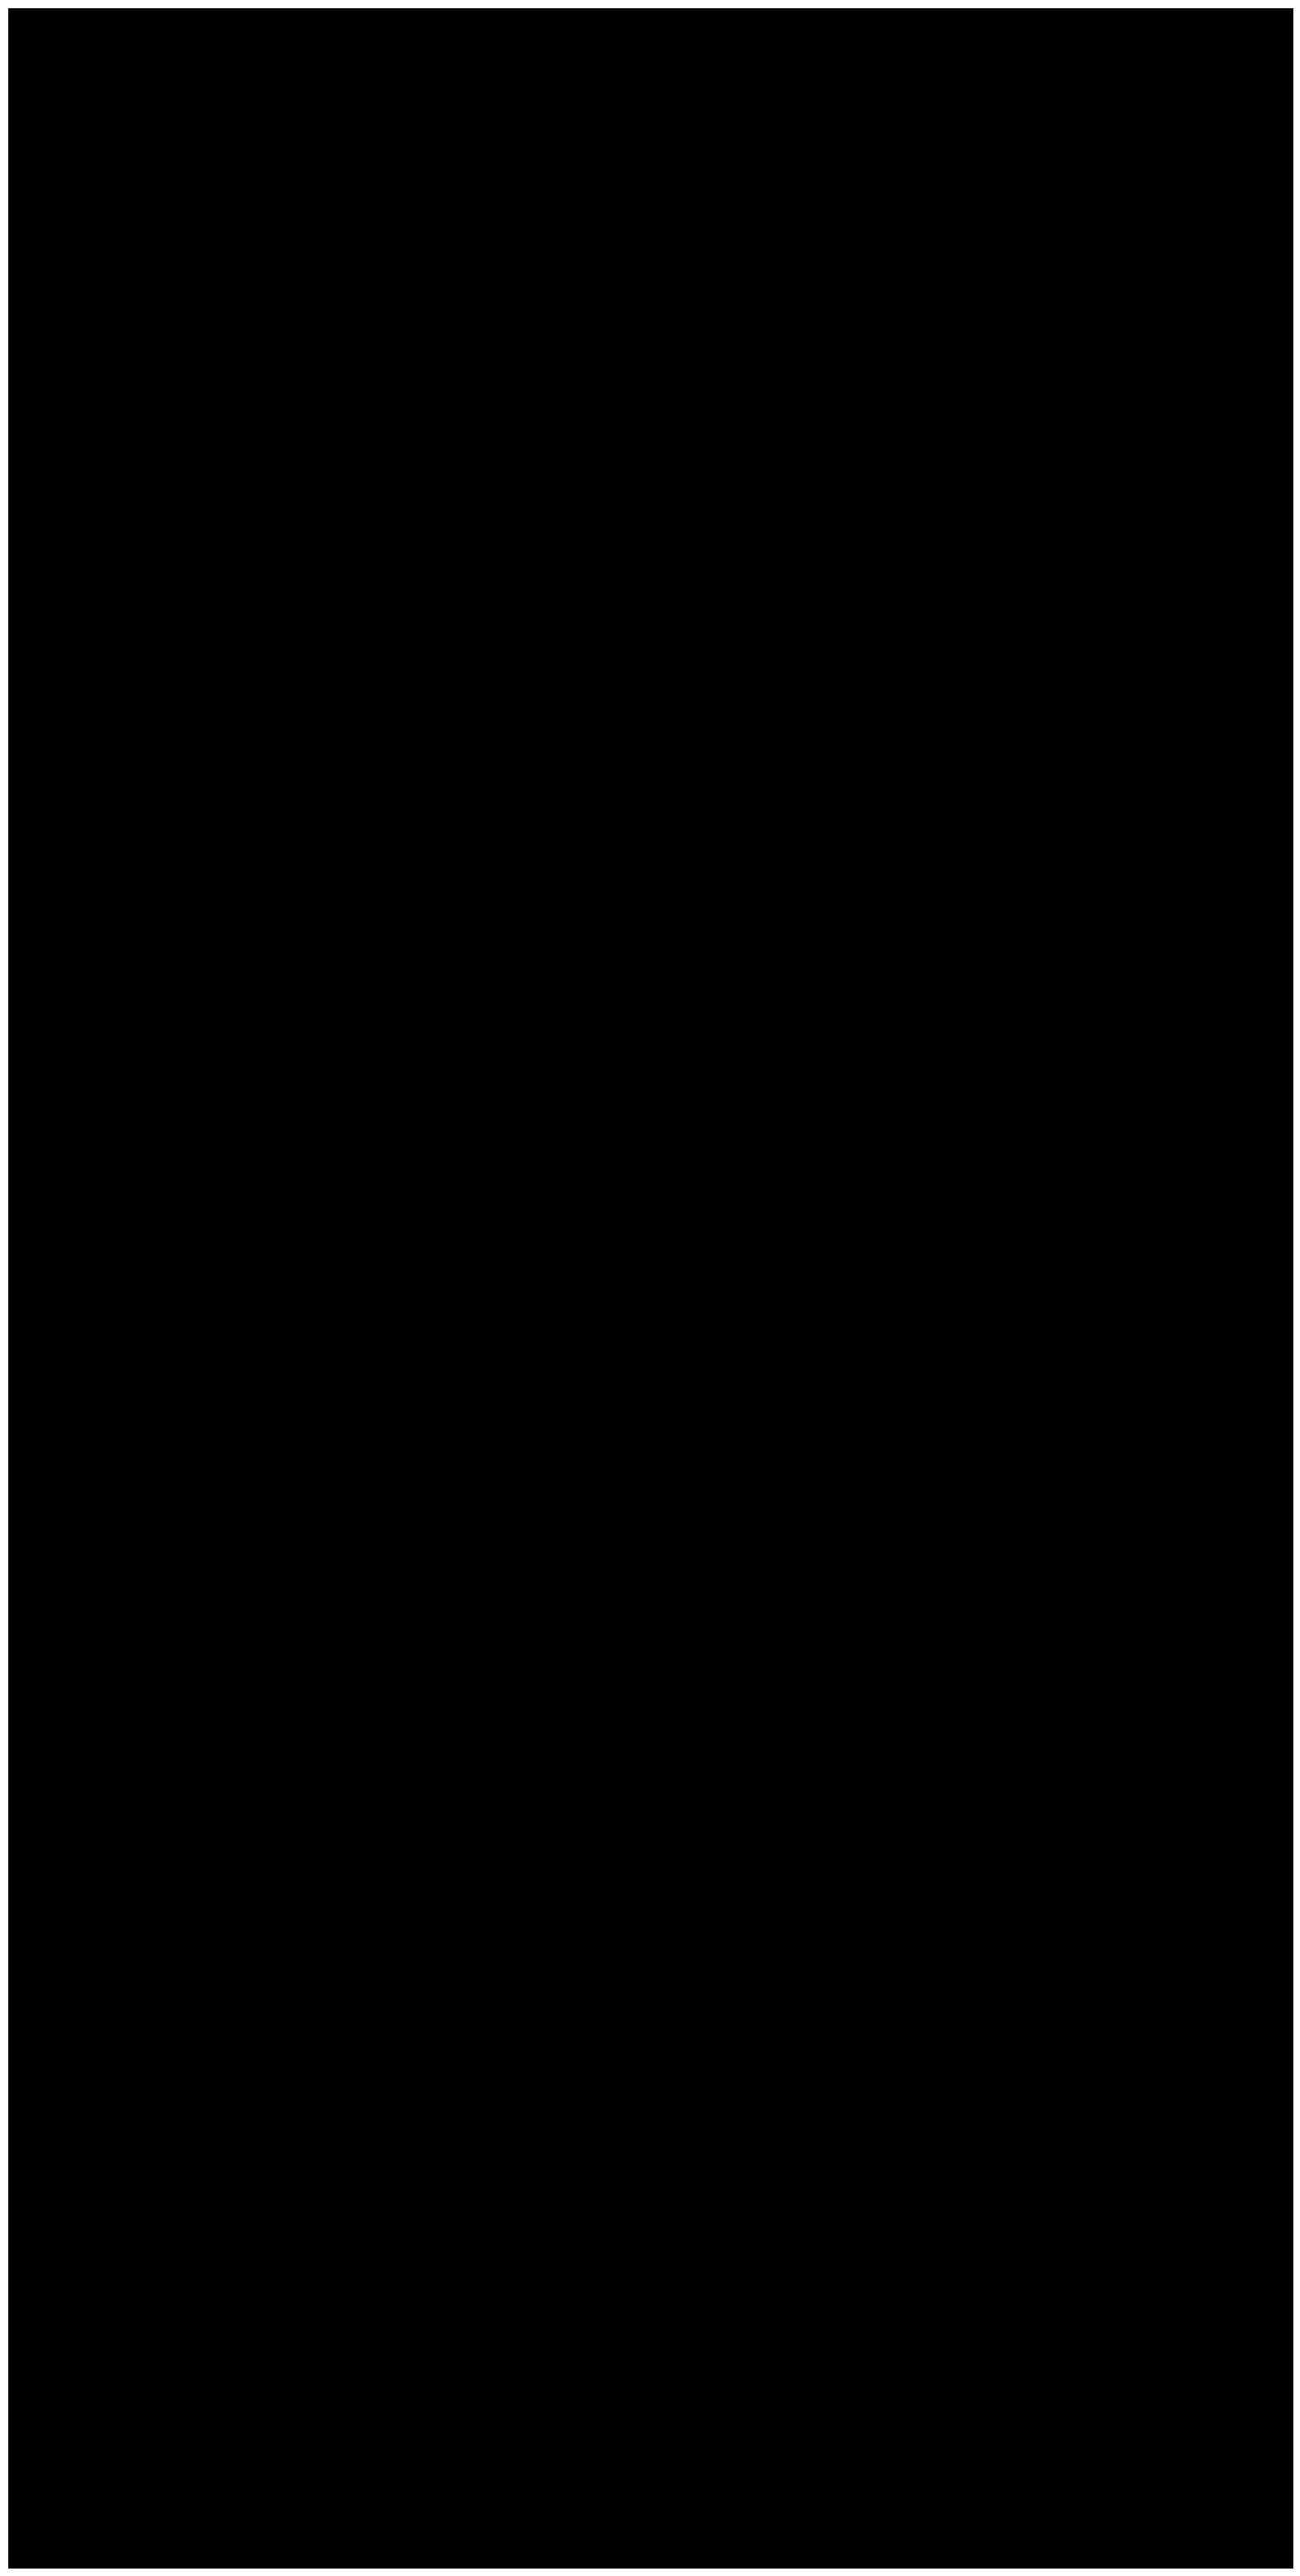

In [10]:
test_input, _ = next(iter(test_dl))
test_input = test_input.to(device)

# mean = [0.47889522, 0.47227842, 0.43047404]
# std = [0.24205776, 0.23828046, 0.25874835]

invnorm = transforms.Compose(
    [
        transforms.Normalize(mean = [0., 0., 0.], std = [1/0.24205776, 1/0.23828046, 1/0.25874835]),
        transforms.Normalize(mean = [-0.47889522, -0.47227842, -0.43047404], std = [1., 1., 1.]),
    ]
)

model.eval()
with torch.no_grad():
    recons, _, _ = model(test_input)

    inv_recons = invnorm(recons)

grid = make_grid(inv_recons)
show(grid)

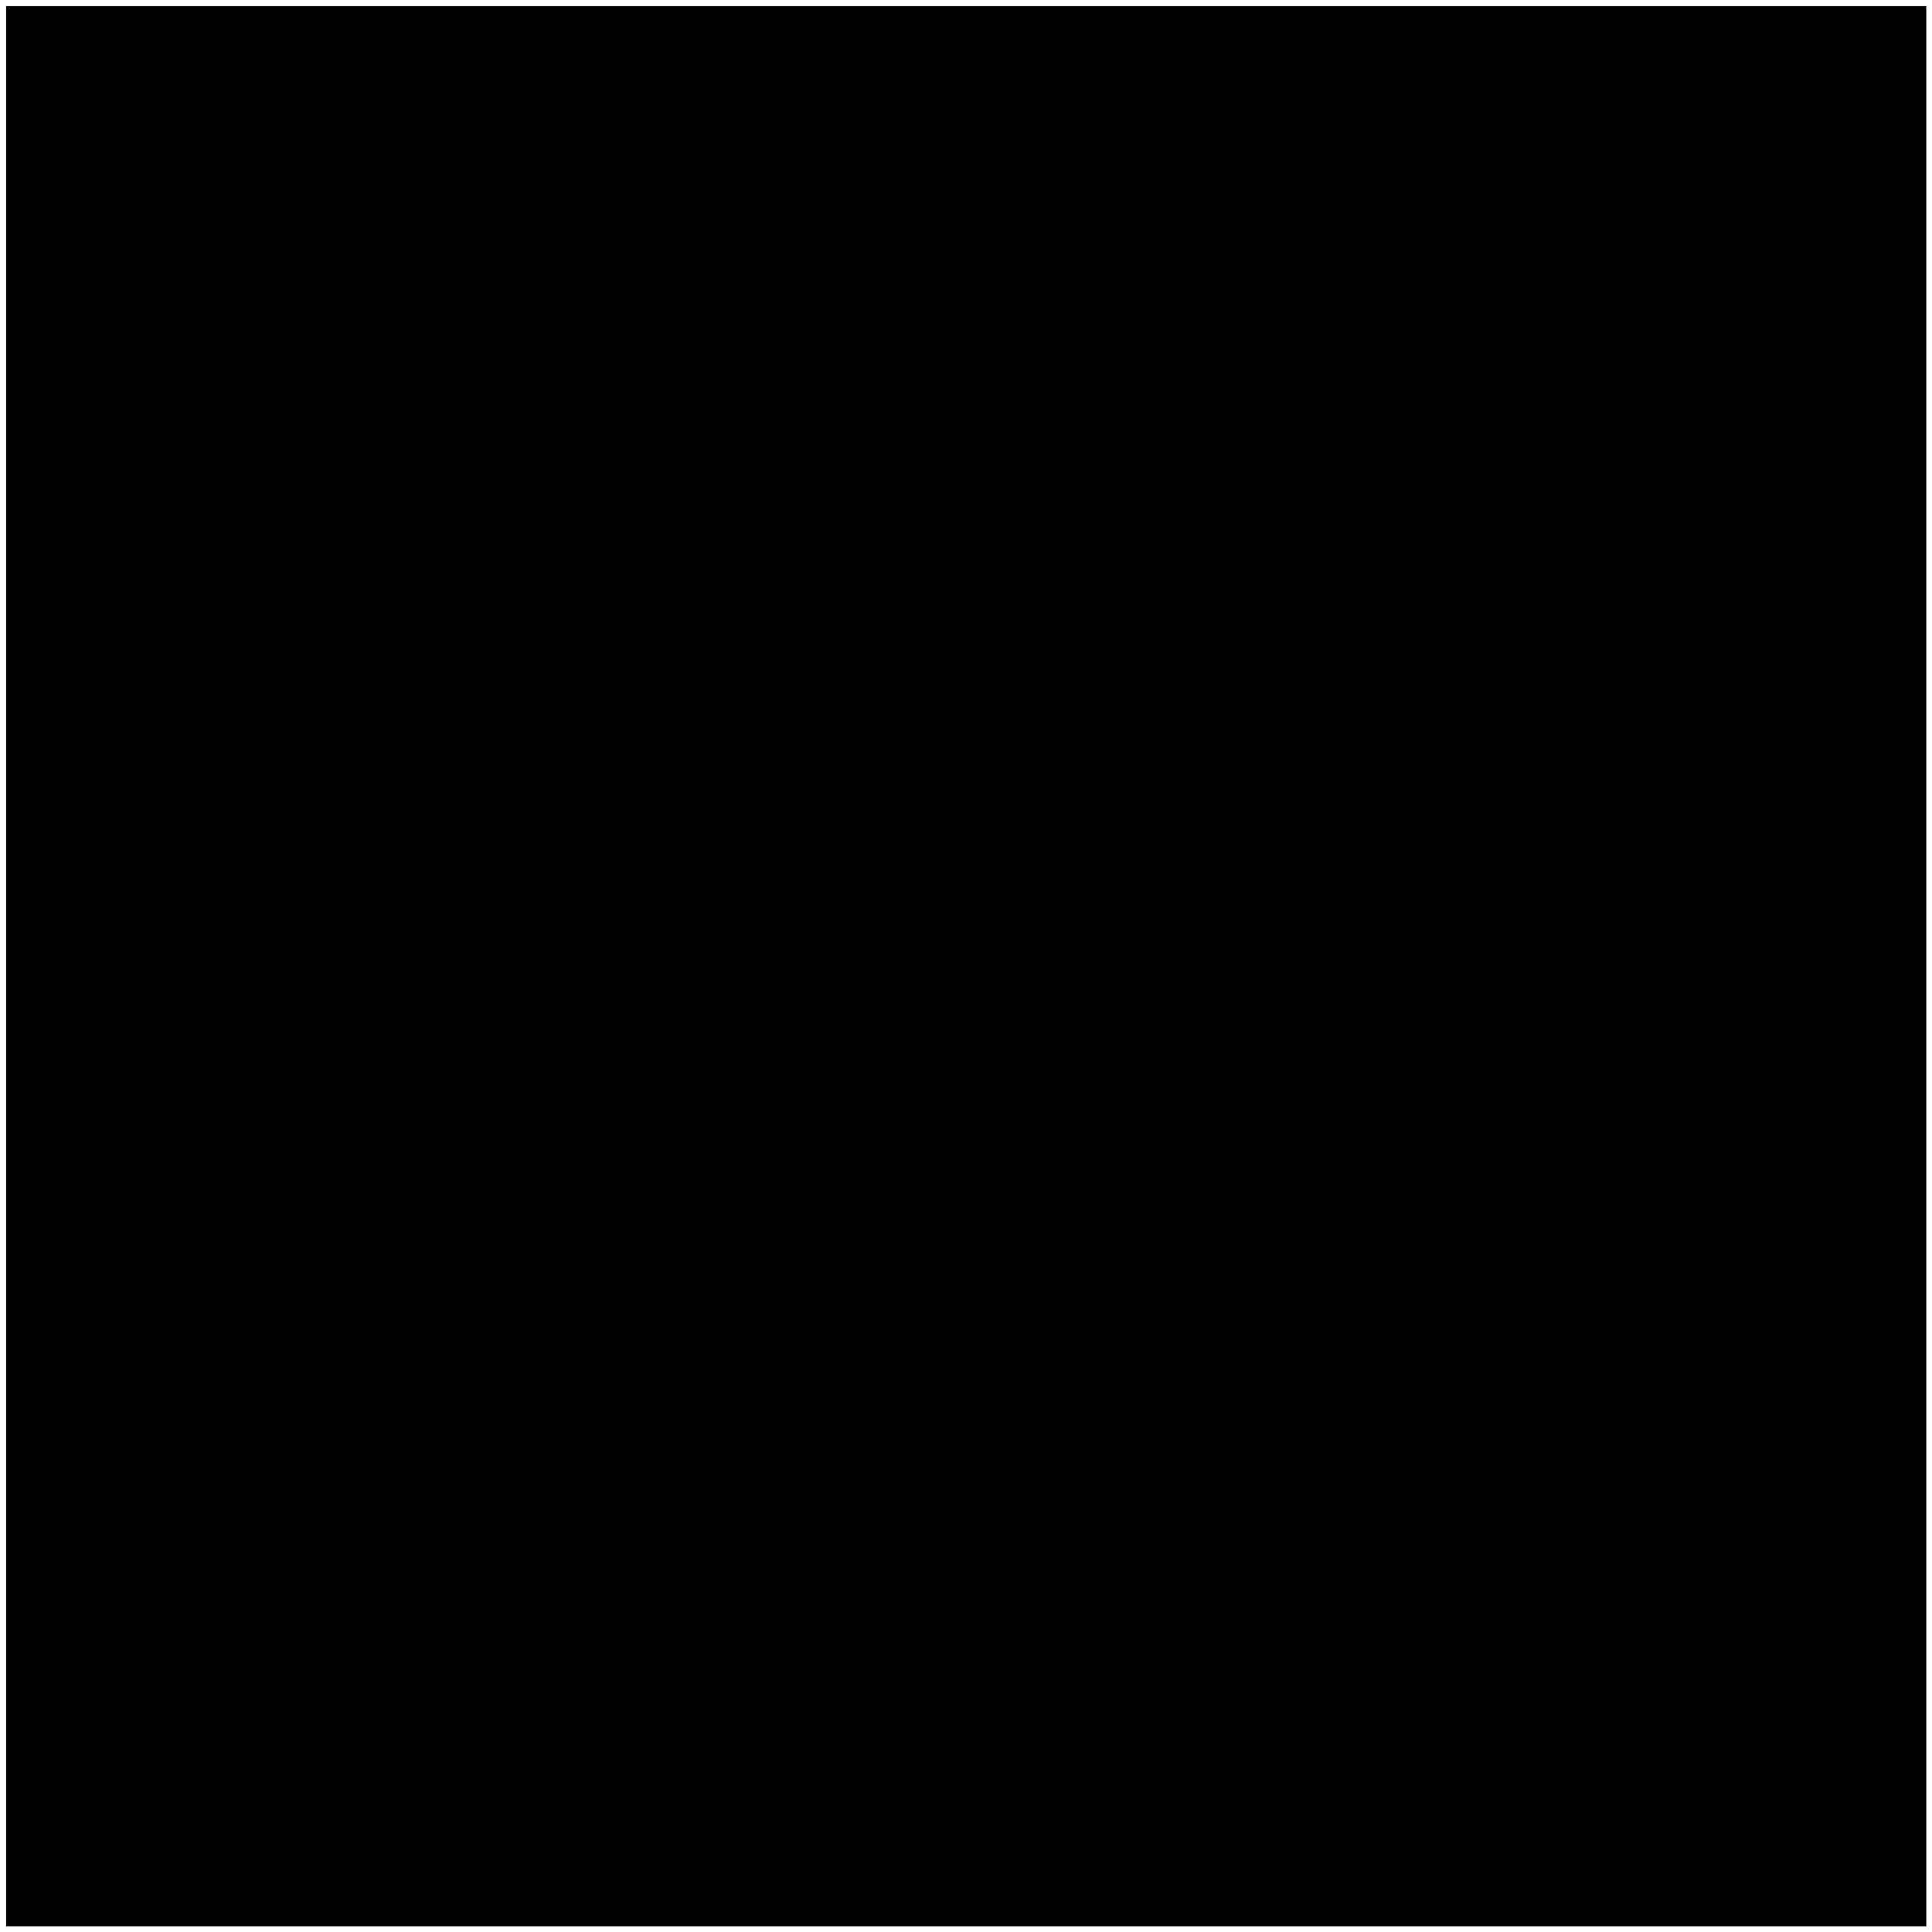

In [11]:
z = torch.randn(144, 512).to(device)

samples = model.decoder(z)

grid = make_grid(invnorm(samples), nrow=12)
show(grid)